## Load Data

The h5 file contains three component: 

1. raw audio data

2. label (direction of arrival)

3. stft (short time fourier transform for 100ms split)

In [ ]:
import h5py
import numpy as np

# Path to the H5 file
h5_file_path = r"C:\Users\grizi\Desktop\TUD\year2\thesis\neural_network\dataset_tools\car_test_dataset_2.h5"

# Open the H5 file
with h5py.File(h5_file_path, 'r') as h5file:
    # Iterate through each dataset in the H5 file
    for dataset_name in h5file:
        # Get the dataset
        dataset = h5file[dataset_name]
        if dataset_name == 'sound_data':
            audio_data = np.array(dataset)
        elif dataset_name == 'label_data':
            label_data = np.array(dataset)
        elif dataset_name == 'stft':
            stft_data = np.array(dataset)
        elif dataset_name == 'azimuth':
            angle_data = np.array(dataset)
        
        # Print the dataset name and its shape
        print(f"Dataset: {dataset_name}, Shape: {dataset.shape}")

print(label_data)
print(stft_data.shape)
angles = []
for i in range (len(label_data)):
    angles.append(int(np.arctan2(label_data[i][2],label_data[i][0])/np.pi*180))
print(angles)

Dataset: azimuth, Shape: (4,)
Dataset: label_data, Shape: (4, 3)
Dataset: sound_data, Shape: (4, 3584, 32)
Dataset: stft, Shape: (4, 64, 84, 15)
[[  5.59237733  -1.76545627  11.35012728]
 [  5.77294771  -1.57941236   8.96171078]
 [  5.83846119  -1.41399675   6.96879121]
 [  6.98078334   0.06851877 -11.21110403]]
(4, 64, 84, 15)
[63, 57, 50, -58]
[ 49.42061381  49.99758469  50.73491961 -44.82491522]


## Label Encoding 

Encode the label to a Gaussian Distribution 

In [7]:
def generate_gaussian(center, start, end, peak_value=1, sigma=1):

    x = np.arange(start, end + 1)  # Generate the range from start to end
    gaussian = np.exp(-0.5 * ((x - center) ** 2) / (sigma ** 2))  # Gaussian formula
    gaussian = gaussian / gaussian.max() * peak_value  # Normalize to make the peak value equal to `peak_value`
    return gaussian

# Generate Gaussian distribution from 1 to 11 with peak at 6
start, end, center = 1, 31, 15
sigma = 2  # Standard deviation
gaussian_distribution = generate_gaussian(center, start, end, peak_value=1, sigma=sigma)

gaussian_distribution

array([2.28973485e-11, 6.69158609e-10, 1.52299797e-08, 2.69957850e-07,
       3.72665317e-06, 4.00652974e-05, 3.35462628e-04, 2.18749112e-03,
       1.11089965e-02, 4.39369336e-02, 1.35335283e-01, 3.24652467e-01,
       6.06530660e-01, 8.82496903e-01, 1.00000000e+00, 8.82496903e-01,
       6.06530660e-01, 3.24652467e-01, 1.35335283e-01, 4.39369336e-02,
       1.11089965e-02, 2.18749112e-03, 3.35462628e-04, 4.00652974e-05,
       3.72665317e-06, 2.69957850e-07, 1.52299797e-08, 6.69158609e-10,
       2.28973485e-11, 6.10193668e-13, 1.26641655e-14])

In [8]:
zero_matrix_train = np.zeros((len(angles),360))

# Define the Gaussian distribution function
def gaussian_labeling(label, num_classes=360):

    zero_row = np.zeros((num_classes))
    for i in range(31):
        center = label + i - 15
        if center < 0:
            center = 360 + center
        elif center > 359:
            center = center - 360
        zero_row[center] = gaussian_distribution[i]*20

    return zero_row

    

# set the method for encoding the labels
encode_method = "gaussian"

# encode the labels as a gaussian distribution
possibility_matrix_angle = zero_matrix_train

for i in range(len(angles)):
    ground_truth_angle = int(angles[i])  # Ground truth angle
    possibility_matrix_angle[i,:] = gaussian_labeling(ground_truth_angle, 360)


# possibility_matrix now contains the Gaussian-encoded labels
print(possibility_matrix_angle.shape)
print(np.argmax(possibility_matrix_angle[3]))


(4, 360)
301


## Model Construction

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Shortcut connection
        out = F.relu(out)
        return out

class DOA_Network(nn.Module):
    def __init__(self, input_channels=64, time_steps=7, doa_bins=360):
        super(DOA_Network, self).__init__()
        
        # 1x7 Convolution, stride (1,3), output channels 32
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=128, kernel_size=(1, 7), stride=(1, 2))
        self.bn1 = nn.BatchNorm2d(128)
        
        # 1x5 Convolution, stride (1,2), output channels 128
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1, 5), stride=(1, 2))
        self.bn2 = nn.BatchNorm2d(256)
        
        # 5 Residual Blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(5)])
        
        # 1x1 Convolution, output channels 360 (DOA bins)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=doa_bins, kernel_size=(1, 1))
        self.bn3 = nn.BatchNorm2d(doa_bins)
        
        # 1x1 Convolution, output channels 500
        self.conv4 = nn.Conv2d(in_channels=18, out_channels=500, kernel_size=(1, 1))
        self.bn4 = nn.BatchNorm2d(500)
        
        # 7x5 Convolution, output channels 1 (Final Spatial Spectrum Output)
        self.conv5 = nn.Conv2d(in_channels=500, out_channels=1, kernel_size=(15, 5), padding=(0, 2))
        
    def forward(self, x):
        # Initial convolutions
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        
        # Residual blocks
        x = self.res_blocks(x)
  
        
        # 1x1 Convolution to DOA bins
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Swap axes (B, T, DOA, F) -> (B, T, F, DOA)
        stage1_x = x
        x = x.permute(0, 3, 2, 1) 
        
        # 1x1 Convolution
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Final 7x5 Convolution with Sigmoid activation
        x = torch.sigmoid(self.conv5(x))
        
        # Remove channel dimension and return (B, T, DOA)
        x = x.squeeze(1).squeeze(1)
        return x, stage1_x

# Example usage
if __name__ == "__main__":
    # Define input dimensions (Batch, Channels, Time, Frequency)
    batch_size = 4
    input_tensor = torch.randn(batch_size, 64, 15, 84)  # (B, C, T, F)
    
    model = DOA_Network()
    output,xx = model(input_tensor)
    print("Output shape:", output.shape)  # Expected: (B, T, 360)


Output shape: torch.Size([4, 360])


## Loss Function Definition

First we define a loss function for the first training stage, then we have to ensure that the loss function has a gradient that could be used in the backward session.

In [ ]:
class Stage1_loss(nn.Module):
    def __init__(self):
        super(Stage1_loss, self).__init__()
        self.mse = nn.MSELoss(reduction='none')  # Calculate MSE loss without reduction

    def forward(self, y_pred, y_true):
        """
        Compute Stage1 Loss:
        1. Calculate MSE loss for each element in the (7, 25) region.
        2. Average the loss over the (7, 25) region.
        3. Average the loss over all samples and all feature dimensions to get a scalar loss.

        Parameters:
        - y_pred: (batch_size, 360, 7, 25) - Predicted tensor
        - y_true: (batch_size, 360) - Ground truth tensor

        Returns:
        - final_loss: Scalar loss value
        """
        
        # Expand y_true to match y_pred shape (batch_size, 360, 7, 25)
        y_true_expanded = y_true.unsqueeze(-1).unsqueeze(-1)  # (4, 360, 1, 1)

        # Calculate MSE loss element-wise: result shape -> (batch_size, 360, 7, 25)
        loss = self.mse(y_pred, y_true_expanded)

        # Compute the mean loss over the last two dimensions (7, 25) -> (batch_size, 360)
        loss_mean_per_feature = loss.mean(dim=(-1, -2))

        # Compute the mean loss over all samples and features -> scalar
        final_loss = loss_mean_per_feature.mean()

        return final_loss


# Instantiate the loss function
loss_fn = Stage1_loss()
y_pred = torch.randn((4, 360, 7, 25),requires_grad=True)  # Random prediction
y_true = torch.randn(4, 360)  # Random ground truth

# Compute the loss
loss = loss_fn(y_pred, y_true)

print("Loss:", loss.item())

# Attempt backpropagation
loss.backward()  # Should work correctly
print("Backward successful!")

the shape of the loss is  torch.Size([4, 360, 7, 25])
Loss: 2.061224937438965
Backward successful!


c:\Users\grizi\anaconda3\envs\dt-test\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 360, 1, 1])) that is different to the input size (torch.Size([4, 360, 7, 25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Training 

### Training Stage 1

In this part, our goal is to train the intermediate representation of shape (360, 7, 25) to approximate a (1, 360) vector that encodes directional information. From my understanding, training on a larger, more detailed intermediate representation first can simplify the learning process, making it easier for the neural network to converge compared to directly training the final (1, 360) output.

c:\Users\grizi\anaconda3\envs\dt-test\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 360, 1, 1])) that is different to the input size (torch.Size([4, 360, 15, 18])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


the shape of the loss is  torch.Size([4, 360, 15, 18])
Epoch : 0, set : 2/1, loss : 4.254630088806152
Epoch [1/2000], Loss: 4.2546
the shape of the loss is  torch.Size([4, 360, 15, 18])
Epoch : 1, set : 2/1, loss : 3.966973066329956
Epoch [2/2000], Loss: 3.9670
the shape of the loss is  torch.Size([4, 360, 15, 18])
Epoch : 2, set : 2/1, loss : 3.8073484897613525
Epoch [3/2000], Loss: 3.8073
the shape of the loss is  torch.Size([4, 360, 15, 18])
Epoch : 3, set : 2/1, loss : 3.7175064086914062
Epoch [4/2000], Loss: 3.7175
the shape of the loss is  torch.Size([4, 360, 15, 18])
Epoch : 4, set : 2/1, loss : 3.738173246383667
Epoch [5/2000], Loss: 3.7382
the shape of the loss is  torch.Size([4, 360, 15, 18])
Epoch : 5, set : 2/1, loss : 3.687311887741089
Epoch [6/2000], Loss: 3.6873
the shape of the loss is  torch.Size([4, 360, 15, 18])
Epoch : 6, set : 2/1, loss : 3.605933427810669
Epoch [7/2000], Loss: 3.6059
the shape of the loss is  torch.Size([4, 360, 15, 18])
Epoch : 7, set : 2/1, loss

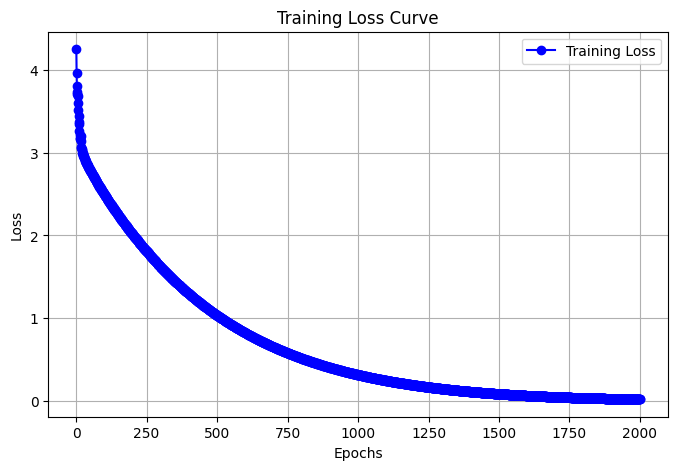

Model weights saved to C:\Users\grizi\Desktop\TUD\year2\thesis\neural_network\DoA_Net\model\DOA_Network_stage1.pth


In [30]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    loss_history = []  # Store loss for each epoch
    
    for epoch in range(num_epochs):
        total_loss = 0
        index = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs,stage1_output = model(inputs)
            # print(stage1[0,:,0,0])
            loss = criterion(stage1_output, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            index += 1
            print(f"Epoch : {epoch}, set : {index+1}/{len(train_loader)}, loss : {loss}")
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Plot training curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-', color='b', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Prediction function
def predict(model, input_tensor, device):
    model.eval()
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        output = model(input_tensor)
    return output.cpu()

# Example usage
if __name__ == "__main__":
    # Define input dimensions (Batch, Channels, Time, Frequency)
    batch_size = 4
    input_tensor = torch.from_numpy(stft_data[:4,:,:,:]).float()
    input_tensor = input_tensor.permute(0, 1, 3, 2)  # Swap axes (B, F, T, C)
    target_tensor = torch.from_numpy(possibility_matrix_angle[:4,:]).float()
    
    # Create dataset and dataloader
    dataset = CustomDataset(input_tensor, target_tensor)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, loss function, and optimizer

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # torch.cuda.set_per_process_memory_fraction(0.6, device=device)

    model = DOA_Network().to(device)
    criterion = Stage1_loss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs=2000)

# save the weight of the model
model_save_path = r"C:\Users\grizi\Desktop\TUD\year2\thesis\neural_network\DoA_Net\model\DOA_Network_stage1.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")



### Training Stage 2

In the second training phase, based on the previously trained model, we use the MSE loss to measure the difference between the model's output (1, 360) and the corresponding label (1, 360).

In [36]:
# Training function for continued training
def stage2_training(model, train_loader, criterion, optimizer, device, num_epochs=1):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Forward pass with the model
            outputs, stage1 = model(inputs)

            # Compute loss using Stage 1 outputs
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Print progress
            print(f"Epoch: {epoch}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        # Print average loss per epoch
        print(f"Epoch [{epoch}/{num_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")

    print("stage2 training completed.")

# set the MSEloss as the criterion for the stage 2 training
criterion = nn.MSELoss()

# set the epoch for the second stage
num_epochs = 20

# freeze the layers which does not need training 
for name, param in model.named_parameters():
    if not any(layer in name for layer in ["conv4", "bn4", "conv5"]):  
        param.requires_grad = False  

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)


# Continue training the model
stage2_training(model, train_loader, criterion, optimizer, device, num_epochs)

# save the weight of the model
model_save_path = r"C:\Users\grizi\Desktop\TUD\year2\thesis\neural_network\DoA_Net\model\DOA_Network_stage2.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")




Epoch: 0, Batch: 1/1, Loss: 3.4210
Epoch [0/20], Average Loss: 3.4210
Epoch: 1, Batch: 1/1, Loss: 3.4210
Epoch [1/20], Average Loss: 3.4210
Epoch: 2, Batch: 1/1, Loss: 3.4210
Epoch [2/20], Average Loss: 3.4210
Epoch: 3, Batch: 1/1, Loss: 3.4210
Epoch [3/20], Average Loss: 3.4210
Epoch: 4, Batch: 1/1, Loss: 3.4209
Epoch [4/20], Average Loss: 3.4209
Epoch: 5, Batch: 1/1, Loss: 3.4200
Epoch [5/20], Average Loss: 3.4200
Epoch: 6, Batch: 1/1, Loss: 3.4189
Epoch [6/20], Average Loss: 3.4189
Epoch: 7, Batch: 1/1, Loss: 3.4180
Epoch [7/20], Average Loss: 3.4180
Epoch: 8, Batch: 1/1, Loss: 3.4179
Epoch [8/20], Average Loss: 3.4179
Epoch: 9, Batch: 1/1, Loss: 3.5292
Epoch [9/20], Average Loss: 3.5292
Epoch: 10, Batch: 1/1, Loss: 3.7317
Epoch [10/20], Average Loss: 3.7317
Epoch: 11, Batch: 1/1, Loss: 3.5280
Epoch [11/20], Average Loss: 3.5280
Epoch: 12, Batch: 1/1, Loss: 3.5287
Epoch [12/20], Average Loss: 3.5287
Epoch: 13, Batch: 1/1, Loss: 3.4297
Epoch [13/20], Average Loss: 3.4297
Epoch: 14, B

### Testing 

First we need to define a new prediction function for our model which has two output (intermediate output and final output)

In [37]:
def predict(model, input_tensor, device):
    model.eval()
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        output, stage1_output = model(input_tensor)  # Unpack the tuple
    return output.cpu(), stage1_output.cpu()  # Apply .cpu() to each tensor


In [38]:
print(input_tensor.shape)
print(target_tensor.shape)
for k in range(len(input_tensor)):
    test_input = input_tensor[k:k+1,:,:,:]
    prediction, stage1_output = predict(model, test_input, device)
    angle_pre = 0
    for i in range (stage1_output.shape[2]):
        for j in range (stage1_output.shape[3]):
            angle_pre += torch.argmax(stage1_output[0,:,i,j]).item()

    angle_pre = angle_pre/ (stage1_output.shape[2]*stage1_output.shape[3])
    print("The average angle of the parameter is",angle_pre)

    max_index = torch.argmax(prediction[0,:]).item()
    print(f"Maximum value index: {max_index}")

    label = torch.argmax(target_tensor[k,:]).item()
    print(f"Label: {label}")

torch.Size([4, 64, 15, 84])
torch.Size([4, 360])
The average angle of the parameter is 62.0
Maximum value index: 56
Label: 62
The average angle of the parameter is 56.0
Maximum value index: 50
Label: 56
The average angle of the parameter is 49.0
Maximum value index: 44
Label: 49
The average angle of the parameter is 301.0
Maximum value index: 296
Label: 301


In [9]:
# Prediction example
test_input = input_tensor[:4,:,:,:]
prediction, stage1_output = predict(model, test_input, device)
print("Prediction shape:", prediction.shape)
print("Stage1 output shape:", stage1_output.shape)
print(prediction.shape)

angle_pre = 0
for i in range (stage1_output.shape[2]):
    for j in range (stage1_output.shape[3]):
        angle_pre += torch.argmax(stage1_output[3,:,i,j]).item()

angle_pre = angle_pre/ (stage1_output.shape[2]*stage1_output.shape[3])
print("The average angle of the parameter is",angle_pre)

max_intermediate = torch.argmax(stage1_output[0,:,3,0]).item()
max_index = torch.argmax(prediction[0,:]).item()
print(f"Maximum value index: {max_index,max_intermediate}")

max_index = torch.argmax(target_tensor[3,:]).item()
print(f"Maximum value index (label): {max_index}")

AttributeError: 'tuple' object has no attribute 'cpu'